# Neural Networks: Explaining Image Classification using LIME

## Set Up - With ImageDataGenerator

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras import models

In [21]:
def visualize_training_results(history):
    '''
    From https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    
    Input: keras history object (output from trained model)
    '''
    fig, (ax1, ax2) = plt.subplots(2, sharex=True)
    fig.suptitle('Model Results')

    # summarize history for accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_ylabel('Accuracy')
    ax1.legend(['train', 'test'], loc='upper left')
    # summarize history for loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_ylabel('Loss')
    ax2.legend(['train', 'test'], loc='upper left')
    
    plt.xlabel('Epoch')
    plt.show()

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 14s 0us/step


In [3]:
pd.Series(y_train.reshape(50000)).value_counts()

6    5000
9    5000
4    5000
1    5000
2    5000
7    5000
8    5000
3    5000
5    5000
0    5000
dtype: int64

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
input_shape = (32, 32, 3) # Size of each image - 32x32 for 3 layers
num_classes = 10

In [6]:
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [10]:
x_train[0].max()

255

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2,
    rescale= 1.0/255)
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(x_train)

In [12]:
pretrained = tf.keras.applications.vgg19.VGG19(
    weights='imagenet',
    include_top=False, # Allows us to set input shape
    input_shape=input_shape) 
# May download data at this step, shouldn't take long

80150528/80134624 [==============================] - 0s 0us/step


In [13]:
model = models.Sequential()
model.add(pretrained)

# freezing layers so they don't get re-trained with your new data
for layer in model.layers:
    layer.trainable=False 

In [14]:
# adding our own dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 20,091,338
Trainable params: 66,954
Non-trainable params: 20,024,384
_________________________________________________________________


With this you can now compile and fit your model!

In [16]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [22]:
# fits the model on batches with real-time data augmentation:
history = model.fit(
    datagen.flow(x_train, y_train, 
                 batch_size=32, subset='training'),
    validation_data=datagen.flow(x_train, y_train,
                                 batch_size=8, subset='validation'),
    epochs=5)

Epoch 1/5
1250/1250 [==============================] - 44s 35ms/step - loss: 1.2379 - accuracy: 0.5637 - val_loss: 1.2269 - val_accuracy: 0.5630
Epoch 2/5
1250/1250 [==============================] - 44s 35ms/step - loss: 1.2027 - accuracy: 0.5749 - val_loss: 1.2069 - val_accuracy: 0.5752
Epoch 3/5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.1732 - accuracy: 0.5818 - val_loss: 1.1855 - val_accuracy: 0.5811
Epoch 4/5
1250/1250 [==============================] - 43s 34ms/step - loss: 1.1524 - accuracy: 0.5909 - val_loss: 1.1639 - val_accuracy: 0.5868
Epoch 5/5
1250/1250 [==============================] - 43s 35ms/step - loss: 1.1371 - accuracy: 0.5979 - val_loss: 1.1532 - val_accuracy: 0.5888


Test loss: 36.34606170654297
Test accuracy: 0.41339999437332153


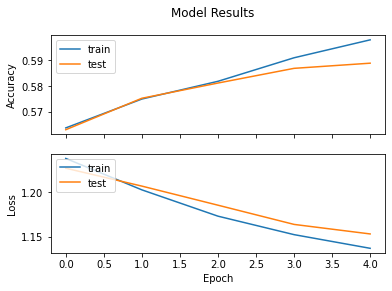

In [23]:
# Evaluate!
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

# Visualize results
visualize_training_results(history)

In [77]:
# Without datagen

vgg = models.Sequential()
vgg.add(pretrained)

# freezing layers so they don't get re-trained with your new data
for layer in vgg.layers:
    layer.trainable=False 

vgg.add(layers.Flatten())
vgg.add(layers.Dense(128, activation='relu'))
vgg.add(layers.Dense(num_classes, activation='softmax'))

vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 20,091,338
Trainable params: 66,954
Non-trainable params: 20,024,384
_________________________________________________________________


In [78]:
vgg.compile(loss='categorical_crossentropy',
            optimizer="adam",
            metrics=['accuracy'])

In [79]:
history = vgg.fit(x_train,
                  y_train,
                  epochs=5, 
                  batch_size=64,
                  validation_data=(x_test, y_test))

Epoch 1/5
782/782 [==============================] - 16s 19ms/step - loss: 2.4541 - accuracy: 0.4322 - val_loss: 1.4170 - val_accuracy: 0.5132
Epoch 2/5
782/782 [==============================] - 15s 19ms/step - loss: 1.2864 - accuracy: 0.5536 - val_loss: 1.2913 - val_accuracy: 0.5627
Epoch 3/5
782/782 [==============================] - 15s 19ms/step - loss: 1.1756 - accuracy: 0.5898 - val_loss: 1.2436 - val_accuracy: 0.5816
Epoch 4/5
782/782 [==============================] - 15s 19ms/step - loss: 1.1253 - accuracy: 0.6092 - val_loss: 1.2491 - val_accuracy: 0.5817
Epoch 5/5
782/782 [==============================] - 15s 19ms/step - loss: 1.0895 - accuracy: 0.6222 - val_loss: 1.2701 - val_accuracy: 0.5812


## Building Out Model Explainability Using LIME

https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb

In [57]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
print('Notebook run using keras:', tf.keras.__version__)

Notebook run using keras: 2.8.0


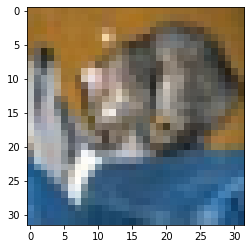

In [58]:
plt.imshow(x_test[0]);

In [39]:
y_test[0] # Class 4

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [81]:
vgg.predict(x_test[:1])

array([[5.1805505e-04, 1.5002806e-03, 5.7349238e-03, 2.8459519e-01,
        7.4449936e-03, 1.0818046e-01, 5.8879811e-01, 2.0031945e-03,
        9.9309185e-04, 2.3162780e-04]], dtype=float32)

In [80]:
vgg.predict(x_test[:1]).argmax() + 1 # Predicted class: +1 b/c zero index

7

In [65]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 32.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=72fbe020643e0092cee9652d292b66ee0a51abb9ec5caf0291a32122e8b77bee
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [100]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

In [82]:
explainer = lime_image.LimeImageExplainer()

In [99]:
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is 
# NONE, the superpixel will be replaced by the average of its pixels

explanation = explainer.explain_instance(x_test[0].astype('double'), 
                                         vgg.predict, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

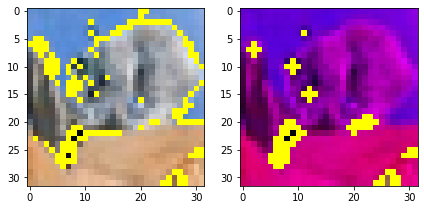

In [112]:
# Visualize the explanation:
temp1, mask1 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                              positive_only=True, 
                                              num_features=5, 
                                              hide_rest=False)
temp2, mask2 = explanation.get_image_and_mask(explanation.top_labels[0], 
                                              positive_only=False, 
                                              num_features=10, 
                                              hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,7))
ax1.imshow((mark_boundaries(temp1, mask1)*255).astype(np.uint8))
ax2.imshow((mark_boundaries(temp2, mask2)*255).astype(np.uint8));